
<br><br>
<div align="center"> <font size="+3" color='#0f6dff'> <b>Anàlisi de temàtiques de notícies - Processament del Llenguatge Natural</b> </font> </div>

<br>

<div align="center"> <font size="+2" color='#5296ff'> <b> Joaquim Morera i Català - Aarón W. Montiel Nicholas </b> </font> </div>

   
<br>

# Taula de Continguts

* [1. Introducció](#intro)


* [2. Llibreries](#llibreries)


* [3. Anàlisi de les dades](#analisi_dades)

    * [3.1 Lectura de les dades](#lectura_dades)
    
    * [3.2 Anàlisi de les variables](#analisis_variables)
    
        * [3.2.1 URLS](#urls)
        
        * [3.2.2 Temps](#temps)
        
        * [3.2.3 Text](#text)
        
            * [3.2.3.1 Web Scrapping](#web)
            
    * [3.3 Enllestiment de les dades](#enllestiment)
    
    
* [4. Preprocessament del text ](#preprocessament)

    * [4.1 Per a keyword extraction](#keyword)
    
    * [4.2 Per al Topic Modeling](#topic)
    
    
* [5. Extracció de Característiques](#extracció)

    * [5.1 Evolució de les Keywords més importants](#evolucio_keyword) 
    
    * [5.2 Topic Modeling amb LDA](#topic_lda)
        
        * [5.2.1  Visualització del model LDA](#visualitzacio)

        * [5.2.2   Pertinença de cada document al tòpic](#pertienca)
        
        * [5.2.3  Notícia més representativa de cada tòpic](#noticia)
                
        * [5.2.4  Distribució de notícies per tòpics](#distribucio)
        
        * [5.2.4  Distribució de notícies per tòpics](#distribucio)
        
        
    
<br><br>


# 1.Introducció <a class="anchor" id="intro"></a>


Utilitzant el conjunt de textos disponible en [aquest enllaç](http://oceano.uv.es/sb/noticias_economicas.zip), que consisteix en 10000 notícies econòmiques en castellà extretes entre el 2015 i el 2021, hem dut a terme un modelatge de temàtiques per a analitzar l'evolució dels temes més importants per any. 

Amb un model global hem identificat i observat l'evolució de les **paraules clau** més importants durant el període esmentat i amb un model de modelatge de temàtiques, hem identificat els tòpics que van apareixent i desapareixent amb el temps.

Per fer-ho, hem fet servir tècniques de Web Scrapping, gestió de dades i algorismes de PLN.



# 2. Llibreries <a class="anchor" id="llibreries"></a>

Procedim a carregar les llibreries necessàries

In [1]:
# Llibreries generals
import pandas as pd
import numpy as np
import datetime

# NLP
import spacy

# Strings
import re
import string

# Llibreria Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import CoherenceModel, LdaModel

# Web Scrapping
import requests
from bs4 import BeautifulSoup

# Ferramentes per a dibuixar
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

#Textacy
import textacy
from textacy import * 
import textacy.ke

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer


# 3. Anàlisi de les dades <a class="anchor" id="analisi_dades"></a>

## 3.1 Lectura de les dades <a class="anchor" id="lectura_dades"></a>

In [2]:
# carreguem les dades
data = pd.read_csv("data/noticias-economicas-sample.csv", engine='python',encoding='utf8', error_bad_lines=False)

# modifiquem el tipus de dada de les variables temporals
data["insert_date"] = pd.to_datetime(data["insert_date"])
data["publish_date"] = pd.to_datetime(data["publish_date"])

# Observem les primeres files 
data.head()

,url,base_url,authors,title,summary,text,publish_date,top_image_url,keywords,insert_date
0,https://www.expansion.com/economia/2020/11/24/...,https://www.expansion.com/mercados/cronica-bol...,Christian Marquardt,La confianza empresarial de Alemania vuelve a ...,CHRISTIAN MARQUARDT / POOL EFELa confianza emp...,Angela Merkel ayer en Berlin tras la cumbre te...,2020-11-24 00:00:00,https://phantom-expansion.unidadeditorial.es/a...,"noviembre, confianza, empresarial, económica, ...",2020-11-24 12:00:00
1,https://www.expansion.com/blogs/quemada/2020/1...,https://www.expansion.com/mercados/cronica-bol...,NaN,El Covid dejará 10 cambios que te afectarán,NaN,\n\n\n\n\nEnrique Quemada Clariana\nFusiones y...,2020-11-06 01:00:00,https://e00-expansion.uecdn.es/assets/desktop/...,"dejará, covid, cambios, afectarán",2020-11-07 01:00:00
2,https://cincodias.elpais.com/cincodias/2020/12...,https://cincodias.elpais.com/tag/ibex_35/,"Ediciones Cinco Días, Getty Images",Quiero ser mi propio jefe,¿Cuántas veces no ha querido ser su propio jef...,¿Cuántas veces no ha querido ser su propio jef...,2020-12-10 00:00:00,https://d500.epimg.net/cincodias/imagenes/2020...,"ser, quiero, propio, negocio, jefe",2020-12-14 12:00:00
3,https://elpais.com/sociedad/2020-12-04/illa-es...,https://cincodias.elpais.com/tag/ibex_35/,"Pedro Gorospe, Javier Etxezarreta",Illa estima que entre mayo y junio pueden esta...,Javier Etxezarreta / EFEEl ministro de Sanidad...,"El ministro de Sanidad, Salvador Illa, momento...",2020-12-04 00:00:00,https://imagenes.elpais.com/resizer/N92W5q5ZxY...,"mayo, illa, pueden, millones, estima, vacunada...",2020-12-04 12:00:00
4,https://www.bolsamania.com/noticias/economia/c...,https://www.bolsamania.com/indice/IBEX-35/noti...,Web Financial Group,El Congreso aprueba los Presupuestos con 188 v...,El Pleno del Congreso ha aprobado el proyecto ...,El Pleno del Congreso ha aprobado el proyecto ...,NaT,https://img2.s3wfg.com/web/img/images_uploaded...,"millones, congreso, presupuestos, favor, aprue...",2020-12-03 12:00:00


 - Seleccionem les columnes que ens interessen. Ens quedem amb *url, text, insert-date i publish-date*

In [3]:
data=data[["url", "text", "insert_date", "publish_date"]]
data.head()

,url,text,insert_date,publish_date
0,https://www.expansion.com/economia/2020/11/24/...,Angela Merkel ayer en Berlin tras la cumbre te...,2020-11-24 12:00:00,2020-11-24 00:00:00
1,https://www.expansion.com/blogs/quemada/2020/1...,\n\n\n\n\nEnrique Quemada Clariana\nFusiones y...,2020-11-07 01:00:00,2020-11-06 01:00:00
2,https://cincodias.elpais.com/cincodias/2020/12...,¿Cuántas veces no ha querido ser su propio jef...,2020-12-14 12:00:00,2020-12-10 00:00:00
3,https://elpais.com/sociedad/2020-12-04/illa-es...,"El ministro de Sanidad, Salvador Illa, momento...",2020-12-04 12:00:00,2020-12-04 00:00:00
4,https://www.bolsamania.com/noticias/economia/c...,El Pleno del Congreso ha aprobado el proyecto ...,2020-12-03 12:00:00,NaT


## 3.2 Anàlisi de les variables <a class="anchor" id="analisi_variables"></a>

En aquesta secció procedirem a analitzar les variables que són del nostre interés de cara a aconseguir el nostre objectiu.

### 3.2.1 URLS <a class="anchor" id="urls"></a>
- Procedim a netejar la url per a crear una nova variable `url_short` amb sols el domini

In [4]:
data["url_short"] = data["url"].str.extract(r'(\w*\.\w+)\/')

In [5]:
data.head()

,url,text,insert_date,publish_date,url_short
0,https://www.expansion.com/economia/2020/11/24/...,Angela Merkel ayer en Berlin tras la cumbre te...,2020-11-24 12:00:00,2020-11-24 00:00:00,expansion.com
1,https://www.expansion.com/blogs/quemada/2020/1...,\n\n\n\n\nEnrique Quemada Clariana\nFusiones y...,2020-11-07 01:00:00,2020-11-06 01:00:00,expansion.com
2,https://cincodias.elpais.com/cincodias/2020/12...,¿Cuántas veces no ha querido ser su propio jef...,2020-12-14 12:00:00,2020-12-10 00:00:00,elpais.com
3,https://elpais.com/sociedad/2020-12-04/illa-es...,"El ministro de Sanidad, Salvador Illa, momento...",2020-12-04 12:00:00,2020-12-04 00:00:00,elpais.com
4,https://www.bolsamania.com/noticias/economia/c...,El Pleno del Congreso ha aprobado el proyecto ...,2020-12-03 12:00:00,NaT,bolsamania.com


- De quins mitjans prové la informació proporcionada?

In [6]:
data["url_short"].value_counts()

elpais.com                    5297
expansion.com                 1916
bolsamania.com                 981
estrategiasdeinversion.com     719
hosteltur.com                  397
noticiasdebolsa.es             273
finanzas.com                   232
sincroguia.tv                   67
as.com                          66
huffingtonpost.es               24
iahorro.com                     13
vodafone.es                      5
socialinvestor.es                5
eventosyconferenciasue.com       1
noticiasibex35.com               1
elmundo.es                       1
home.kpmg                        1
guiadelocio.com                  1
Name: url_short, dtype: int64

### 3.2.2 Text <a class="anchor" id="text"></a>

- Qualitat del text

Observant text de les notícies ens n'adonem que existeixen mostres que no són notícies en sí. En aquest cas, trobem que la mostra 72 conté en el text la política de Cookies

In [7]:
data["text"][72]

'Nuestra página usa cookies y otras tecnologías para que podamos mejorar nuestros servicios y mostrarte publicidad relacionada con tus preferencias, estudiando tus habitos de navegación. Si continuas navegando, consideramos que aceptas su uso. Si quieres saber más sobre las cookies y tecnologías similares, entra en Saber más\n\nAcepto'

Fem una xicoteta anàlisi i observem com totes les notícies que tenen la paraula cookies, no tenen data d'inserció

In [8]:
data["publish_date"][data["text"].str.match(".*(cookies)")].isnull().value_counts()

True    71
Name: publish_date, dtype: int64

 Identifiquem quins són els mitjans que en el text tenen la informació relativa a les cookies

In [9]:
data["url_short"][data["text"].str.match(".*(cookies)")].value_counts()

bolsamania.com    33
sincroguia.tv     19
expansion.com     19
Name: url_short, dtype: int64

Decidim eliminar aquestes notícies que no són profitoses en el nostre objectiu

In [10]:
data=data[data["text"].str.match(".*(cookies)")==False]
data.shape[0] #ara tenim 10.000 - 71 notícies 

9929

Ara tenim 9929 noticies que són del nostre interés (10.000 - 71 = 9929 notícies)

- Distribució el nombre de paraules i caràcters

Analitzem la distribució de les paraules i dels caràcters de les notícies

In [11]:
summary = []

# Per a cada notícia, guardem dades sobre el text
for c in data["text"]:
    summary.append({
        'NCaracters': len(c),
        'NParaules': len(c.split()),

    })

resumen = pd.DataFrame(summary)

Mirem quina és la distribució del nombre de paraules i caràcters per a cada diari:

In [12]:
resumen["url_short"]= data["url_short"]
resumen.groupby("url_short").describe()

NCaracters                                      \
                                count          mean          std      min   
url_short                                                                   
as.com                           66.0   3555.772727  2174.769659    240.0   
bolsamania.com                  934.0   3582.934690  4627.891919     66.0   
elmundo.es                        1.0   6437.000000          NaN   6437.0   
elpais.com                     5265.0   3782.222222  5417.382700     21.0   
estrategiasdeinversion.com      713.0   3704.193548  5004.016484     43.0   
eventosyconferenciasue.com        1.0   3054.000000          NaN   3054.0   
expansion.com                  1887.0   3688.450980  4723.500812     21.0   
finanzas.com                    232.0   3803.991379  5466.199265    100.0   
guiadelocio.com                   1.0    612.000000          NaN    612.0   
home.kpmg                         1.0  16830.000000          NaN  16830.0   
hosteltur.com                   393.0   3883.992366  6087.836522    113.0   
huffingtonpost.es                24.0   4100.291667  2682.628764    209.0   
iahorro.com                      13.0   3099.153846  2482.384232    396.0   
noticiasdebolsa.es              270.0   3513.355556  3938.330659     88.0   
noticiasibex35.com                1.0    139.000000          NaN    139.0   
sincroguia.tv                    48.0   3789.145833  2971.142949     21.0   
socialinvestor.es                 5.0   4140.000000  2811.516317    213.0   
vodafone.es                       5.0   3512.400000  1633.646014   1815.0   

                                                                  NParaules  \
                                 25%      50%       75%       max     count   
url_short                                                                     
as.com                       1874.25   3218.0   5067.25    8177.0      66.0   
bolsamania.com               1295.00   2822.0   4747.50  100000.0     934.0   
elmundo.es                   6437.00   6437.0   6437.00    6437.0       1.0   
elpais.com                   1547.00   2977.0   4880.00  100000.0    5265.0   
estrategiasdeinversion.com   1428.00   2904.0   4642.00  100000.0     713.0   
eventosyconferenciasue.com   3054.00   3054.0   3054.00    3054.0       1.0   
expansion.com                1393.00   2895.0   4721.50  100000.0    1887.0   
finanzas.com                 1623.50   2914.5   4808.50   60836.0     232.0   
guiadelocio.com               612.00    612.0    612.00     612.0       1.0   
home.kpmg                   16830.00  16830.0  16830.00   16830.0       1.0   
hosteltur.com                1678.00   3016.0   4742.00  100000.0     393.0   
huffingtonpost.es            1891.75   3726.0   6088.00    9601.0      24.0   
iahorro.com                  1378.00   2542.0   4424.00    9095.0      13.0   
noticiasdebolsa.es           1484.25   2876.5   4803.50   52107.0     270.0   
noticiasibex35.com            139.00    139.0    139.00     139.0       1.0   
sincroguia.tv                2178.75   2826.0   4764.25   14736.0      48.0   
socialinvestor.es            3223.00   4425.0   4857.00    7982.0       5.0   
vodafone.es                  2781.00   3040.0   3774.00    6152.0       5.0   

                                                                              \
                                   mean         std     min      25%     50%   
url_short                                                                      
as.com                       593.848485  367.987134    38.0   315.25   545.0   
bolsamania.com               589.902570  712.307402    11.0   216.00   470.5   
elmundo.es                  1179.000000         NaN  1179.0  1179.00  1179.0   
elpais.com                   620.912251  837.913172     3.0   251.00   492.0   
estrategiasdeinversion.com   607.349229  755.548279    10.0   246.00   479.0   
eventosyconferenciasue.com   548.000000         NaN   548.0   548.00   548.0   
expansion.com                

Vient la existència de notícies amb un nombre de caràcters molt baix, decidim establir un llindar en 175 caràcters. Observem algunes mostres de notícies que no arriben a aquest llindar:

In [13]:
data["text"][data["text"].map(len)<175]

5       Vacunarse de la gripe para aliviar los hospita...
206     Tráiler de 'Godzilla VS Kong'\n\nExpansion.com...
294     Buscar otra fecha\n\nUtiliza el calendario o l...
500     © DIARIO AS, S.L. - Valentín Beato, 44 - 28037...
709     Buscar otra fecha\n\nUtiliza el calendario o l...
                              ...                        
9048    Alemania se cierra para combatir el coronaviru...
9105    Buscar otra fecha\n\nUtiliza el calendario o l...
9456    Exitoso alunizaje de la sonda china Change 5\n...
9685                             \n403 Forbidden\nnginx\n
9885    Fútbol\n\nEl fan que llamó chulo a Riqui Puig ...
Name: text, Length: 65, dtype: object

Descobrim algunes repeticions en el text, com aquells que comencen per *Buscar otra fecha* o *403 Forbidden*. Decidim esbrinar quins són els mitjans que en el text tenen la informació relativa a la primera frase frase:

In [14]:
data["url_short"][data["text"].str.match("^(Buscar otra fecha)")].value_counts()

elpais.com    18
Name: url_short, dtype: int64

Procedim a eliminar les notícies amb un nombre menor de 175 caràcters ja que no són profitoses en el nostre objectiu

In [15]:
data=data[data["text"].map(len)>175]
data.shape[0]  

9862

Ara tenim 9862 notícies en el nostre dataset

### 3.2.3 Temps <a class="anchor" id="temps"></a>


- Analitzem la variable `insert_date`

In [16]:
print(data["insert_date"].dt.year.value_counts())
print("\nNombre notícies que tenen insert_date: ",data["insert_date"].dt.year.value_counts().sum())

2020    6940
2021    2922
Name: insert_date, dtype: int64

Nombre notícies que tenen insert_date:  9862


No n'hi ha dades faltants i se concentren en només 2 anys

- Analitzem la variable `publish_date`

In [17]:
print(data["publish_date"].dt.year.value_counts())
print("\nNombre notícies que tenen publish_date: ",data["publish_date"].dt.year.value_counts().sum())

2020.0    5249
2021.0    2114
2018.0      57
2019.0      38
2017.0      14
2016.0       3
2015.0       2
Name: publish_date, dtype: int64

Nombre notícies que tenen publish_date:  7477


Trobem que n'hi ha dades faltants, i que tenim més valors d'anys en `publish_date` que en `insert_date` 

Analitzem quins són els mitjans que tenen valors faltants en `publish_date`

In [18]:
data["url_short"][data["publish_date"].isnull()].value_counts()

bolsamania.com                931
estrategiasdeinversion.com    715
hosteltur.com                 397
finanzas.com                  218
sincroguia.tv                  48
expansion.com                  45
elpais.com                     24
socialinvestor.es               5
home.kpmg                       1
eventosyconferenciasue.com      1
Name: url_short, dtype: int64

Veient que gairebé un 25% de les notícies no tenen `publish_date`, decidim emprar tècniques de Web Scrapping per a tractar d'imputar-les.

In [19]:
#Definim un dataset pròpi per a les dades faltants
dades_faltants = data[data["publish_date"].isnull()]

#### 3.2.3.1 Web Scrapping  <a class="anchor" id="web"></a>
- Web Scrapping en **bolsamania.com**

In [20]:
# Definim variables que ens serviran en l'obtenció de les dades
# Per a canviar text a numero
l = {"ene":"1", "feb":"2", "mar":"3", "abr":"4", "may":"5", "jun":"6", "jul":"7", "ago":"8", "sep":"9", "oct":"10", "nov":"11", "dic":"12"}

# Funció específica de bolsamania.com
def tipus_ul_li(tag):
    return tag.name=='ul' and tag.find("li")

In [21]:
dates=[]
for url in dades_faltants["url"][dades_faltants["url"].str.match(".*(bolsamania\.com)")]:
  try:
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    taula=soup.find( "div",{"class":"author-header"})
    temps=taula.find_all(tipus_ul_li)[1]
    
    
    date= temps.find("li").text
    for word, initial in l.items():
        date = date.replace(word.lower(), initial)
    
    dates.append( datetime.datetime.strptime(date, '%d %m, %Y %H:%M'))
  except:
    dates.append(pd.Timedelta("nan"))
    

Ara comprovem quantes `publish_date` no hem pogut aconseguir mitjançant Web Scrapping.

In [22]:
len([x for x in dates if type(x)==pd._libs.tslibs.nattype.NaTType])

90


Només 90 notícies de 931 continuen sense tindre `publish_date`. Procedim a imputar les dades que hem aconseguit:

In [23]:
dades_faltants["publish_date"].loc[dades_faltants["url"].str.match('.*(bolsamania\\.com)')] = dates

- Web Scrapping en **estrategiasdeinversion.com**

In [24]:
dates=[]
for url in dades_faltants["url"][dades_faltants["url"].str.match(".*(estrategiasdeinversion\.com)")]:
  try:
    page = requests.get(url)
    # parseamos el html usando BeautifulSoup y lo guardamos en la variable `soup`
    soup = BeautifulSoup(page.text, 'html.parser')
    
    taula=soup.find( "time",{"class":"timestamp"})

    dates.append( datetime.datetime.strptime(taula.text, '%d-%m-%Y, %H:%M:%S'))
  except:
    dates.append(pd.Timedelta("nan"))

Ara comprovem quantes `publish_date` no hem pogut aconseguir mitjançant Web Scrapping.

In [25]:
# Nombre de dades faltants. 
len([x for x in dates if type(x)==pd._libs.tslibs.nattype.NaTType])

10


Només 10 notícies de 715 continuen sense tindre `publish_date`. Procedim a imputar les dades que hem aconseguit:

In [26]:
dades_faltants["publish_date"][dades_faltants["url"].str.match(".*(estrategiasdeinversion\.com)")] = dates

- Web Scrapping en **hosteltur.com**

In [27]:
# Definim variables que ens serviran en l'obtenció de les dades
# Per a canviar text a numero
l = {"enero":"1", "febrero":"2", "marzo":"3", "abril":"4", "mayo":"5", "junio":"6", "julio":"7", "agosto":"8", "septiembre":"9", "octubre":"10", "noviembre":"11", "diciembre":"12"}

In [28]:
dates=[]
for url in dades_faltants["url"][dades_faltants["url"].str.match(".*(hosteltur\.com)")]:
  try:
    page = requests.get(url)
    # parseamos el html usando BeautifulSoup y lo guardamos en la variable `soup`
    soup = BeautifulSoup(page.text, 'html.parser')
    
    taula=soup.find( "span",{"class":"published_at"})
    temps=taula.find("span",{"class":"text"})
    

    date= temps.text.strip()
    for word, initial in l.items():
        date = date.replace(word.lower(), initial)

    dates.append( datetime.datetime.strptime(date, '%d %m, %Y'))
  except:
    dates.append(pd.Timedelta("nan"))

Ara comprovem quantes `publish_date` no hem pogut aconseguir mitjançant Web Scrapping.

In [29]:
# Nombre de dades faltants. 
len([x for x in dates if type(x)==pd._libs.tslibs.nattype.NaTType])

78


Només 78 notícies de 397 continuen sense tindre `publish_date`. Procedim a imputar les dades que hem aconseguit:

In [30]:
dades_faltants["publish_date"][dades_faltants["url"].str.match(".*(hosteltur\.com)")] = dates

- Web Scrapping en **finanzas.com**


In [31]:
dates=[]
for url in dades_faltants["url"][dades_faltants["url"].str.match(".*(finanzas\.com)")]:
  try:
    page = requests.get(url)
    # parseamos el html usando BeautifulSoup y lo guardamos en la variable `soup`
    soup = BeautifulSoup(page.text, 'html.parser')
    
    taula=soup.find( "time",{"class":"entry-date published"})

    dates.append( datetime.datetime.strptime(taula.text, '%d/%m/%Y'))
  except:
    dates.append(pd.Timedelta("nan"))

Ara comprovem quantes `publish_date` no hem pogut aconseguir mitjançant Web Scrapping.

In [32]:
# Nombre de dades faltants. 
len([x for x in dates if type(x)==pd._libs.tslibs.nattype.NaTType])

153


En aquest cas, 153 notícies de 218 continuen sense tindre `publish_date`. Açò és degut a que moltes d'aquestes urls no s'hi troben disponibles a data de realització de l'informe. Procedim a imputar les dades que hem aconseguit:

In [33]:
dades_faltants["publish_date"][dades_faltants["url"].str.match(".*(finanzas\.com)")] = dates

- **sincroguia.tv** i **expansion.com**

Ens n'adonem que les urls relatives a *sincroguia.tv* i a *expansion.com* que no tenen `publish_date` fan referència a sinòpis de pel·lícules i series, i per tant, són textos que no aporten context al nostre problema

In [34]:
# Observem una url d'una mostra de sincroguia.tv
dades_faltants["url"][45]

'https://sincroguia.tv/peliculas/los-mercenarios-3--6ywt-SPA'

In [35]:
# Revisem el text d'aquesta mostra
dades_faltants["text"][45]

"Sinopsis\n\nBarney, Christmas y el resto del equipo deben enfrentarse a Stonebanks, cofundador del grupo, que posteriormente se convirtió en un reconocido y despiadado traficante de armas.\n\n\n\nTercera entrega de 'Los Mercenarios', todo un fenómeno para los amantes del cine de acción. En esta ocasión, Patrick Hughes ('Red Hill') dirige la cinta en la que, además de repetir nombres como Sylvester Stallone, Jason Statham o Arnold Schwarzenegger, se suman nuevas estrellas de Hollywood. Mel Gibson ('Arma letal'), Wesley Snipes ('Blade'), Kelsey Grammer ('Frasier') y Antonio Banderas ('Desperado') se apuntan a este festival de tiros, persecuciones, batallas sin fin y frases lapidarias. Además, Hugues presenta a quienes prometen ser iconos del género como Kellan Lutz ('Hércules: El origen de la leyenda'), Ronda Rousey ('Furious 7') o Glen Powell ('April Apocalypse').\n\n\n\nCabe destacar la presencia de Harrison Ford haciendo de enlace entre los mercenarios y el Gobierno. Esta función la 

Decidim, donada la tipologia del text, eliminar aquestes mostres que no aporten informació al nostre objectiu:

In [36]:
dades_faltants= dades_faltants[dades_faltants["url_short"]!="expansion.com"]
dades_faltants= dades_faltants[dades_faltants["url_short"]!="sincroguia.tv"]

- **elpais.com**

Descobrim que aquelles mostres que no tenen `publish_date` i que pertanyen a *elpais.com* són relatives a les seccions "librotea", secció de llibres i "aprendemosjuntos", magazine conjunt amb BBVA on el text de les quals és la transcripció del vídeo. 

In [37]:
dades_faltants["url"][7792]

'https://aprendemosjuntos.elpais.com/especial/abrazar-a-nuestros-hijos-no-es-malcriarlos-rafa-guerrero/'

In [38]:
dades_faltants["text"][7792] #es una transcripcio d'un video de aprendemosjuntos

'39:50\n\nOtro aspecto muy importante de la autoestima es que seamos conscientes de que no viene ya dada genéticamente. “Qué mala suerte he tenido, que tengo autoestima muy baja”. Desde luego que hay factores y hay elementos que van a incidir para que uno tenga una mayor predisposición en un sentido o en otro sentido, seguro, pero lo que va a determinar en esencia la autoestima tiene que ver con la educación, con los valores y con los objetivos y las interpretaciones que hagamos mamá y papá. Y ya para acabar, me gusta utilizar un concepto que es el de la metáfora del bidón. Si sabemos que nuestra función como madres, padres, docentes, consiste en cubrir sus necesidades, pues imagínate que cada vez que mi hijo, independientemente de la edad que tenga, tiene una necesidad, si yo se la cubro de una manera suficientemente buena, es como si añadiera una sustancia, “responsina”, en ese bidón. Entonces, cada vez que tiene una necesidad, si yo se la cubro, le doy esa micra de “responsina” y en

Decidim, donada la tipologia del text, eliminar aquestes mostres que no aporten informació al nostre objectiu:

In [39]:
dades_faltants= dades_faltants[dades_faltants["url_short"]!="elpais.com"]

- Web Scrapping en **Socialinvestor.es**


In [40]:
dates=[]
for url in dades_faltants["url"][dades_faltants["url"].str.match(".*(socialinvestor\.es)")]:
  try:
    page = requests.get(url)
    # parseamos el html usando BeautifulSoup y lo guardamos en la variable `soup`
    soup = BeautifulSoup(page.text, 'html.parser')
    
    taula=soup.find( "time",{"class":"entry-date published"})

    date= taula.text.strip()
    for word, initial in l.items():
        date = date.replace(word.lower(), initial)

    dates.append( datetime.datetime.strptime(date, '%d %m %Y'))
  except:
    dates.append(pd.Timedelta("nan"))

Ara comprovem quantes `publish_date` no hem pogut aconseguir mitjançant Web Scrapping.

In [41]:
print("Nombre de dades faltants: ",len([x for x in dates if type(x)==pd._libs.tslibs.nattype.NaTType])

Nombre de dades faltants: 0


Aconseguim trobar totes les dates faltants. Procedim a imputar-les:

In [42]:
dades_faltants["publish_date"][dades_faltants["url"].str.match(".*(socialinvestor\.es)")] = dates

- **Resum** del Web Scrapping

D'un total de 2385 dates faltants, hem pogut recuperar 2052: un 86%. La resta de notícies no tenen `publish_date` i decidim eliminar-les per a tindre major certesa en la nostra anàlisi.

Observem en esta taula el resultat d'emprar Web Scrapping per a obtindre `publish_date`:

Mitjà | Abans Web Scrapping  | Després Web Scrapping
--------------|--------------|-----------
bolsamania.com              |  931 | 90
estrategiasdeinversion.com  |  715 | 10
hosteltur.com               |  397 | 78
finanzas.com                |  218 | 153
sincroguia.tv               |   48 | Eliminada
expansion.com               |   45 | Eliminada
elpais.com                  |   24 | Eliminada
socialinvestor.es           |    5 | 0
home.kpmg                   |    1 | 1
eventosyconferenciasue.com  |    1 | 1

## 3.3 Enllestiment de les dades <a class="anchor" id="enllestiment"></a>

- La variable `data_def` recollirà tota la informació completa de les notícies

In [43]:
data_def = pd.concat([data[data["publish_date"].isnull()==False],dades_faltants[ dades_faltants["publish_date"].isnull()==False]], axis=0)

In [44]:
data_def.shape

(9412, 5)

Aquest data.frame ha sigut guardat per a no tindre que tornar a repetir el procés de *web scrapping*

- Comprovem que efectivament, no tenim dades faltants en `publish_date`

In [45]:
data_def['publish_date'].isnull().sum() 

0

- Creem una nova columna `year_quarter`, dels trimestres anuals,  que ens permetrà ordenar les notícies cronològicament més endavant.

In [46]:
data_def["year_quarter"] = data_def["publish_date"].dt.year.map(str)  + "-" + data_def["publish_date"].dt.quarter.map(str)

- Observem quina distribució tenen les notícies en els trimestres de cada any.

In [47]:
data_def["year_quarter"].value_counts().sort_index()

2015-1       1
2015-4       1
2016-1       1
2016-3       1
2016-4       2
2017-3       4
2017-4      10
2018-1      11
2018-2      14
2018-3      13
2018-4      20
2019-1      18
2019-2      11
2019-3       7
2019-4       5
2020-1       9
2020-2      13
2020-3      69
2020-4    6504
2021-1    2698
Name: year_quarter, dtype: int64

- Veiem que la proporció per trimestres és molt desigual. Per tal d'analitzar mínimament l'evolució de les temàtiques al llarg del temps, decidim quedar-nos amb les notícies a partir del quart trimestre de 2017

In [48]:
data_def = data_def[data_def["publish_date"] > datetime.datetime(2017, 9,30)]
data_def["year_quarter"].value_counts().sort_index()

2017-4      10
2018-1      11
2018-2      14
2018-3      13
2018-4      20
2019-1      18
2019-2      11
2019-3       7
2019-4       5
2020-1       9
2020-2      13
2020-3      69
2020-4    6504
2021-1    2698
Name: year_quarter, dtype: int64

In [49]:
print("Ara el tamany del dataset és: ", data_def.shape)

Ara el tamany del dataset és:  (9402, 6)


# 4. Preprocessament del text <a class="anchor" id="preprocessament"></a>

## 4.1 Per a keyword extraction <a class="anchor" id="keyword"></a>

Hem dissenyat un preprocessament que primerament extreu les 20 keywords més rellevants del text, per a posteriorment normalitzar-les.

L'extracció de les keywords es realitza a través del model pre-entrenat TextRank i la normalització mitjançant una funció pròpia. 

Hem valorat que l'extracció de keywords ens permet tindre un corpus més específic per al nostre objectiu, rebutjant al mateix temps, paraules irrellevants. 

Al mateix temps, el tipus de dada que retorna la funció és un `string`, tal i com demana la llibreria `sklearn`


In [50]:
nlp = spacy.load("es_core_news_md")

In [51]:
def unir_ngramas(texto):
    """Une todos los términos de un n-grama mediante '-'
    para que formen un único término en el vocabulario"""
    return [re.sub(r'\s','-', ngram) for ngram in texto]
    
es = textacy.load_spacy_lang("es_core_news_md", disable=("parser",))

def extraer_keywords(texto, topn=20):
    """Extrar las palabras clave de un texto mediante la
    librería textacy
    Devuelve los topn términos clave como lista de strings"""
    #COMPLETAR
    doc = textacy.make_spacy_doc(texto, lang=es)
    return [kps for kps, weights in textacy.ke.textrank(doc, normalize="lemma", topn=topn)]

def normalize_document_sklearn(doc):
    '''Funció pròpia de normalització del document'''
    # eliminem del text els números i signes de puntuació    
    doc = re.sub('[\\d\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]', '', doc)

    # tokenizamos el texto
    tokens = nlp(doc)
    # quitamos puntuación/espacios
    filtered_tokens = [t.text.lower() for t in tokens if len(t.text)>3
                                            and not t.is_punct 
                                            and not t.is_space
                                            and not t.text in nlp.Defaults.stop_words] 
 
    return ' '.join(filtered_tokens)

def normalize_corpus_keywords(corpus):
    """ """
    for text in corpus:
        keywords=extraer_keywords(text)
        yield normalize_document_sklearn(" ".join(unir_ngramas(keywords)))
        

## 4.2 Per al Topic Modeling <a class="anchor" id="topic"></a>

El preprocessamnt que hem emprat per a normalitzar les notícies de cara al topic modeling selecciona paraules amb longitud de més de 3 caràcters i que no són stop-words.

Com que el model LDA que volem fer servir és de la llibreria `gensim`, el tipus de dada que retorna la normalització és una llista de notícies normalitzades.

In [52]:
def normalize_document_gensim(doc):
    '''Funció pròpia de normalització del document'''
    # eliminem del text els números i signes de puntuació    
    doc = re.sub('[\\d\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]', '', doc)

    # tokenizamos el texto
    tokens = nlp(doc)
    # quitamos puntuación/espacios
    filtered_tokens = [t.text.lower() for t in tokens if len(t.text)>3
                                            and not t.is_punct 
                                            and not t.is_space
                                            and not t.text in nlp.Defaults.stop_words] 
 
    return filtered_tokens


def normalize_corpus_gensim(corpus):
    """ """
    return [normalize_document_gensim(text) for text in corpus]

# 5. Extracció de Característiques<a class="anchor" id="extracció"></a>

En els següents apartats analitzem els canvis en el temps de les **paraules més rellevants** i els **tòpics** de les notícies. 

## 5.1 Evolució de les Keywords més importants <a class="anchor" id="evolucio_keyword"></a>

En aquest apartat pretenim identificar les paraules més importants de manera global i observar l'evolució d'aquestes al llarg del temps a través d'un gràfic dinàmic. 

Per fer-ho, preprocessem el text extraient amb el model pre-entrenat *TextRank* les keywords de cada document i les normalitzem. Posteriorment, mitjançant un Bag of Words, fem un compteig i adaptem el dataframe a l'estructura desitjada.

- Preprocessem el text

In [67]:
corpus_noticies = normalize_corpus_keywords(data_def["text"])

- Creem la Bag of Words amb CountVectorizer de `sklearn`

In [68]:
cv= CountVectorizer(token_pattern=r"(?u)\b\w+(?:\-\w*)*\b", min_df=0.005)

cv_matrix= cv.fit_transform(corpus_noticies)

- Creació de la matriu amb les keywords

In [69]:
df=pd.DataFrame(cv_matrix.toarray())

- Afegim la correspondència de cada document amb el seu trimestre

In [70]:
df["year_quarter"]= list(data_def["year_quarter"])

- Agrupem les keywords de les notícies per trimestres

In [71]:
df=df.groupby("year_quarter").sum()

- Trasposem el DataFrame perquè les columnes siguen els trimestres i les files les keywords

In [72]:
df=df.transpose()

- Afegim el nom de la keywords a la columna index

In [73]:
vocab = cv.get_feature_names()
df.index= vocab

- Visualitzem el resultat

In [74]:
df

year_quarter,2017-4,2018-1,2018-2,2018-3,2018-4,2019-1,2019-2,2019-3,2019-4,2020-1,2020-2,2020-3,2020-4,2021-1
accionar,0,0,1,1,1,2,0,0,1,1,0,0,51,30
accionista,0,0,1,0,0,0,0,0,1,0,1,0,44,24
actividad,0,0,0,0,0,0,0,0,0,0,0,0,39,14
actividad-económico,0,0,0,0,0,0,0,0,0,0,0,2,60,22
administración-público,0,0,0,0,0,0,0,0,0,0,0,2,49,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vivienda,0,1,0,0,1,0,0,0,0,0,0,1,31,16
wall-street,0,0,0,3,3,0,1,0,0,0,0,6,54,37
web-noticiasdebolsaes,9,9,13,11,17,10,7,5,4,1,3,9,73,38
zona-euro,0,0,0,0,0,0,0,0,0,0,0,1,55,33


- Guardem aquest dataframe per a realitzar en la plataforma *Flourish* un *bar chart race* per a veure l'evolució de les paraules clau al llarg del temps.

In [75]:
df.to_csv("data/bar_chart_race.csv")

-  Mostrem les keywords més rellevants 

In [76]:
pd.DataFrame({ "keyword":vocab,"total":np.sum(cv_matrix.toarray(),0)}).sort_values("total", ascending=False).head(10)

,keyword,total
137,millón,1339
89,euro,643
87,españa,395
194,reino-unido,365
163,país,340
44,compañía,306
224,trimestre,304
104,gobierno,288
79,empresa,280
74,dólar,246


In [79]:
%%html
<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/6245883"><script src="https://public.flourish.studio/resources/embed.js"></script></div>

## 5.2 Topic Modeling amb LDA <a class="anchor" id="topic_lda"></a>

En aquest apartat fem una anàlisi dels tòpics presents en les notícies a través d'un modelatge amb l'algorisme LDA i comentem els resultats

- Creem la llista de llistes que necessita `gensim` per a crear el diccionari

In [53]:
corpus = normalize_corpus_gensim(data_def["text"]) 

- Creem el diccionari amb el corpus i filtrem les paraules que apareixen en menys de 5 documents i les que ho fan en més del 20%

In [54]:
diccionari = corpora.Dictionary(corpus)
diccionari.filter_extremes(no_above=0.20, no_below=5)

- Construïm el bag of words del model

In [55]:
corpus_bow = [diccionari.doc2bow(doc) for doc in corpus]

- Definim una funció per a evaluar el nombre de topis apropiats a través del valor de la coherència.

In [56]:
def evaluate_graph(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    start: min number of topics
    step: step between topics number swept
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    n_topics = list(range(start, limit, step))
    for num_topics in n_topics:
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = n_topics
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v, n_topics

- Evaluem el nombre de tòpics

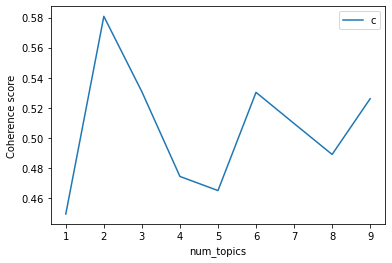

In [57]:
lmlist, c_v, n = evaluate_graph(dictionary=diccionari, corpus=corpus_bow, texts=corpus, limit=10, step=1)

Donat el gràfic, elegirem 5 tòpics per al nostre model

- A través de l'algorisme LDA, creem el model

In [58]:
ldamodel = LdaModel(corpus=corpus_bow, num_topics=5, id2word=diccionari)

###  5.2.1 Visualització del model LDA <a class="anchor" id="visualitzacio"></a>

Observem en dos dimensions els tòpics determinats pel model LDA

In [59]:
vis_data = pyLDAvis.gensim_models.prepare(ldamodel, corpus_bow, diccionari)
pyLDAvis.display(vis_data)

Observant el gràfic resultant pensem que seria apropiat disminuir el número de topics

In [60]:
ldamodel = LdaModel(corpus=corpus_bow, num_topics=4, id2word=diccionari)
vis_data = pyLDAvis.gensim_models.prepare(ldamodel, corpus_bow, diccionari)
pyLDAvis.display(vis_data)

###  5.2.2 Pertinença de cada document al tòpic <a class="anchor" id="pertienca"></a>

Determinem amb la següent funció la pertinença de cada document al tòpic. 

In [61]:
def format_topics_sentences(ldamodel, corpus):
    # inicializa salida
    sent_topics_df = pd.DataFrame()

    # obtiene main topic de cada documento
    for row in ldamodel[corpus]:
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        (topic_num, prop_topic)=row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.reset_index(inplace=True)
    sent_topics_df.columns = ['No_noticia','Topic_dominant', 'Contribucio_per', 'Paraules_clau']
    sent_topics_df['Topic_dominant'] = sent_topics_df['Topic_dominant'].astype('int')
    return(sent_topics_df)

In [62]:
df_notices2topic = format_topics_sentences(ldamodel=ldamodel, corpus=corpus_bow)

In [63]:
df_notices2topic.head()

,No_noticia,Topic_dominant,Contribucio_per,Paraules_clau
0,0,3,0.5636,"plazo, dólares, inversión, puntos, banco, inve..."
1,1,0,0.4434,"servicio, economía, inversión, recuperación, p..."
2,2,0,0.4923,"servicio, economía, inversión, recuperación, p..."
3,3,1,0.9390,"madrid, casos, semana, comunidad, medidas, cor..."
4,4,3,0.6209,"plazo, dólares, inversión, puntos, banco, inve..."


###  5.2.3 Notícia més representativa de cada tòpic  <a class="anchor" id="noticia"></a>

Obtenim les notícies més rellevants de cada tòpic agrupant per tòpics.  

In [64]:
# Agrupem notícies per tòpic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_notices2topic.groupby('Topic_dominant')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Contribucio_per'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Canviem el nom de la columna
sent_topics_sorted.columns = df_notices2topic.columns

# Mostrem
sent_topics_sorted

,No_noticia,Topic_dominant,Contribucio_per,Paraules_clau
0,7201,0,0.9992,"servicio, economía, inversión, recuperación, p..."
1,2046,1,0.9998,"madrid, casos, semana, comunidad, medidas, cor..."
2,387,2,0.9997,"vida, casa, equipo, madrid, gente, explica, es..."
3,8918,3,0.9990,"plazo, dólares, inversión, puntos, banco, inve..."


### 5.2.4 Distribució de notícies per tòpics <a class="anchor" id="distribucio"></a>

Observem quina és la distribució de les notícies pels tòpics.

In [65]:
# núm de documentos por cada tema
topic_counts = df_notices2topic['Topic_dominant'].value_counts()

# porcentaje de documentos por cada tema
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# palabras clave de cada tema
topic_num_keywords = sent_topics_sorted[['Topic_dominant', 'Paraules_clau']]

# Concatenamos por columna
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# cambiamos nombre de columna
df_dominant_topics.columns = ['Topic_dominant', 'Paraules_clau', 'Num_Noticies', 'Perc_Noticies']

# Show
df_dominant_topics

,Topic_dominant,Paraules_clau,Num_Noticies,Perc_Noticies
0,0,"servicio, economía, inversión, recuperación, p...",2433,0.2588
1,1,"madrid, casos, semana, comunidad, medidas, cor...",1415,0.1505
2,2,"vida, casa, equipo, madrid, gente, explica, es...",2283,0.2428
3,3,"plazo, dólares, inversión, puntos, banco, inve...",3271,0.3479


- Recollim les dades que necessitem per a fer el gràfic

In [66]:
df=pd.DataFrame({"year_quarter": list(data_def["year_quarter"]), 
                 "n":1, 
                 
                 "Paraules_clau": list(df_notices2topic["Paraules_clau"]) })

- Agrupem per `year_quarter` i `Paraules_clau`

In [67]:
df=df.groupby(["year_quarter","Paraules_clau"]).sum("n")

- Fem els últims ajustos

In [77]:
df = df.pivot(index='Paraules_clau',columns='year_quarter',values='n')

- Guardem el dataframe

In [79]:
df.to_csv("data/bar_chart_race_topic.csv")

- Visualitzem el gràfic d'evolució de les noticies per tòpic al llarg del temps

In [1]:
%%html
<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/6246223"><script src="https://public.flourish.studio/resources/embed.js"></script></div>